# Dynamic mode decomposition (DMD)
In this example, we will demonstrate the use of dynamic mode decomposition (DMD) for
decomposing a simple linear dynamical system.

This example is inspired from example 1 of

M.S. Hemati, C.W. Rowley, E.A. Deem, and L.N. Cattafesta
   ``De-biasing the dynamic mode decomposition for
     applied Koopman spectral analysis of noisy datasets,''
     Theoretical and Computational Fluid Dynamics (2017).

The example considers a low-rank linear system with
two undamped modes and one dampled mode. The snapshots taken from the
solution of the linear system are noised up with zero-mean Gaussian noise.

In [1]:
using ILMPostProcessing

using LinearAlgebra
using Random
using OrdinaryDiffEq
using Plots

m = 100 # number of snapshots
n = 250 # number of states
r = 6 # rank of DMD
dt = 0.01 # snapshot time step
meas_cov = 0.05 # measurement noise covariance
init_cov = 0.1 # initial condition covariance

0.1

Specify characteristic frequencies and growth/decay rates
associated with continuous-time dynamics.
The DMD rank should be set equal to twice the number of modes
(since each mode consists of conjugate pairs)

In [2]:
f = [1.0, 2.5, 5.5]
g = [0, 0, -0.3]

3-element Vector{Float64}:
  0.0
  0.0
 -0.3

Create the right hand side matrix for the continuous linear system

In [3]:
k = 2*length(f)
A = zeros(k,k)
for ii in 1:length(f)
    i1, i2 = 2*ii-1, 2*ii
    Ai = view(A,i1:i2,i1:i2)
    Ai .= [g[ii] 2π*f[ii]; -2π*f[ii] g[ii]]
end

The true eigenvalues of the system

In [4]:
true_evals = exp.(eigvals(A)*dt)

6-element Vector{ComplexF64}:
 0.9380623563800332 - 0.33772322928201853im
 0.9380623563800332 + 0.33772322928201853im
 0.9876883405951378 - 0.15643446504023087im
 0.9980267284282716 - 0.06279051952931336im
 0.9980267284282716 + 0.06279051952931336im
 0.9876883405951378 + 0.15643446504023087im

Right-hand side of linear system of equations

In [5]:
dynsys(x,p,t) = A*x

dynsys (generic function with 1 method)

### Solve the linear system
Set up a random initial condition with elements drawn from N(1,init_cov)
and solve the problem.

In [6]:
x0 = 1 .+ randn(k)*sqrt(init_cov)

tspan = (0,dt*m)
prob = ODEProblem(dynsys,x0,tspan)
sol = solve(prob,Tsit5(),saveat=dt);

For DMD, use the solution snapshots, but
randomly rotate them and apply noise to each

In [7]:
Q, _ = qr(randn(n,k))
getsnaps(x) = Q*x .+ sqrt(meas_cov)*randn(n)
snaps = map(x -> getsnaps(x),sol.u);

Now perform DMD

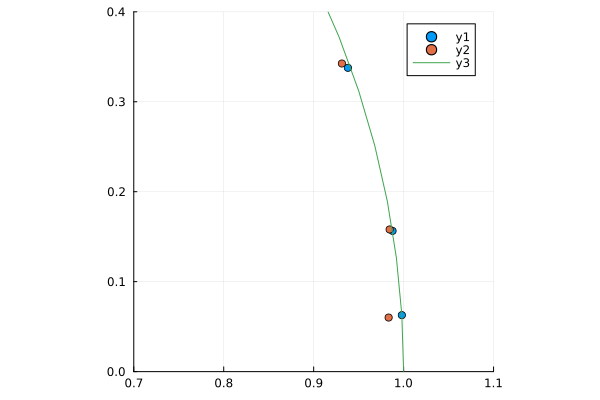

In [8]:
dmdmodes = dmd(snaps,r)

scatter(real(true_evals),imag(true_evals),ratio=1,xlim = (0.7,1.1),ylim=(0,0.4))
scatter!(real(dmdmodes.evals),imag(dmdmodes.evals))
θ = range(0,2π,length=100);
plot!(cos.(θ),sin.(θ))

### Compare the true and DMD-computed eigenvalues
Note that these may not be ordered the same, so we have to
also determine how to permute the order of them to compare
corresponding eigenvalues. We then compute the l2 error

In [9]:
vals, idex = findmin(abs2.(true_evals .- transpose(dmdmodes.evals)),dims=2)
sqrt(sum(vals))

0.024638494809607097

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*